In [2]:
import numpy as np 
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
DIRECTORY_OUT = '/node200data/18parkky/datasets/data/public/processed_data/CRC_MSI_intensity_analysis_clean_data'

PATH_TO_CHEN_CELLTYPES = f'{DIRECTORY_OUT}/Chen_et_al.CellType_Simplified.tsv'
PATH_TO_CHEN_METADATA3  = '/node200data/18parkky/datasets/data/public/FASTQ/Immunotherapy_CRC_Chen_et_al/metadata/Chen_et_al.patient_meta.csv'

PATH_TO_CHEN_ADATA      = f'{DIRECTORY_OUT}/adata_c.preprocessed.NanoMnT.TumorLabeled.h5ad'
PATH_TO_JOANITO_ADATA   = f'{DIRECTORY_OUT}/adata_j.preprocessed.NanoMnT.TumorLabeled.h5ad'

In [ ]:
def calcSampleEnrichment( T_Proportion, N_Proportion, epsilon=(0.1)**6 ):
    return np.log2( (T_Proportion+epsilon)/(N_Proportion+epsilon) )

def getSummarizedInfo( adata, CellTypeProportionByPatient ):

    list_PatientID = list(set(adata.obs['PatientID']))
    dict_PatientID_to_MSI_intensity = { PatientID : np.mean(edf[(edf['Manual_CellType_lvl_2']=='Tumor epithelial')]['MSI_score']) for PatientID, edf in adata.obs.groupby('PatientID', ) } 
    print(dict_PatientID_to_MSI_intensity)
    AssociationWithMSIByCellType = list()

    for CellType, edf in CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor'].groupby('CellType', observed=True,):
        dict_PatientID_to_Proportion = { tup.PatientID : tup.Proportion for tup in edf.itertuples() }
        c = 0
        for PatientID in list_PatientID:
            try: dict_PatientID_to_Proportion[PatientID]
            except KeyError: 
                c += 1
                dict_PatientID_to_Proportion[PatientID] = 0
                
        x, y = [ dict_PatientID_to_Proportion[p] for p in list_PatientID ], [ dict_PatientID_to_MSI_intensity[p] for p in list_PatientID ]
        r, pval = scipy.stats.spearmanr( x, y, )
        # if CellType == 'CD8+ Proliferating T':
        #     sns.regplot(x=x,y=y)
        AssociationWithMSIByCellType.append( [CellType, r, pval, len(list_PatientID)-c] )

    AssociationWithMSIByCellType = pd.DataFrame(AssociationWithMSIByCellType, columns=['CellType', 'R', 'pval', 'n_patients'])

    SampleEnrichmentByCellType = list()
    T_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Tumor']['Count'])
    N_totalCellCount = sum(CellTypeProportionByPatient[CellTypeProportionByPatient['BiopsySite']=='Normal']['Count'])
    dict_BiopsySite_to_TotalCount = { 'Tumor' : T_totalCellCount,'Normal' : N_totalCellCount }

    for CellType, edf in CellTypeProportionByPatient.groupby('CellType'):
        # dict_BiopsySite_to_Proportion = { tup.BiopsySite : tup.Proportion for tup in edf.itertuples() }
        dict_BiopsySite_to_Proportion = { BiopsySite : sum(edf2['Count'])/dict_BiopsySite_to_TotalCount[BiopsySite] for BiopsySite, edf2 in edf.groupby('BiopsySite') }
        if 'Tumor' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Tumor'] = 0 
        if 'Normal' not in list(dict_BiopsySite_to_Proportion.keys()): dict_BiopsySite_to_Proportion['Normal'] = 0 

        SampleEnrichmentByCellType.append( [CellType, calcSampleEnrichment(dict_BiopsySite_to_Proportion['Tumor'], dict_BiopsySite_to_Proportion['Normal'])] )
    SampleEnrichmentByCellType = pd.DataFrame(SampleEnrichmentByCellType, columns=['CellType', 'Enrichment'])

    dict_CellType_to_SummarizedInfo = dict()
    for tup in SampleEnrichmentByCellType[SampleEnrichmentByCellType['CellType'].isin( AssociationWithMSIByCellType['CellType'] )].itertuples():
        dict_CellType_to_SummarizedInfo[tup.CellType] = [tup.Enrichment] 
    for tup in AssociationWithMSIByCellType[AssociationWithMSIByCellType['CellType'].isin( SampleEnrichmentByCellType['CellType'] )].itertuples():
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.R )
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.pval )
        dict_CellType_to_SummarizedInfo[tup.CellType].append( tup.n_patients )

    SummarizedInfo = pd.DataFrame(dict_CellType_to_SummarizedInfo).T
    SummarizedInfo.reset_index(inplace=True)
    SummarizedInfo.columns = ['CellType', 'TissueEnrichment', 'CorrelationWithMSI', 'Pvalue', 'n_patients']
    return SummarizedInfo

## Load data

In [4]:
adata_c = sc.read_h5ad(PATH_TO_CHEN_ADATA)
adata_j = sc.read_h5ad(PATH_TO_JOANITO_ADATA)

In [9]:
metadata_c3 = pd.read_csv(PATH_TO_CHEN_METADATA3, )

dict_PatientID_to_TumorRegressionRatio = { list(tup)[1] : list(tup)[12] for tup in metadata_c3.itertuples() }
dict_PatientID_to_Response = { list(tup)[1] : list(tup)[13] for tup in metadata_c3.itertuples() }

adata_c.obs['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PID] for PID in adata_c.obs['PatientID'] ]
adata_c.obs['Response'] = [ dict_PatientID_to_Response[PID] for PID in adata_c.obs['PatientID'] ]

## Compare MSI score between CR and PR patients (Fig. 4a)

/tmp/ipykernel_260955/985734869.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=MSI_intensity_by_Patient,


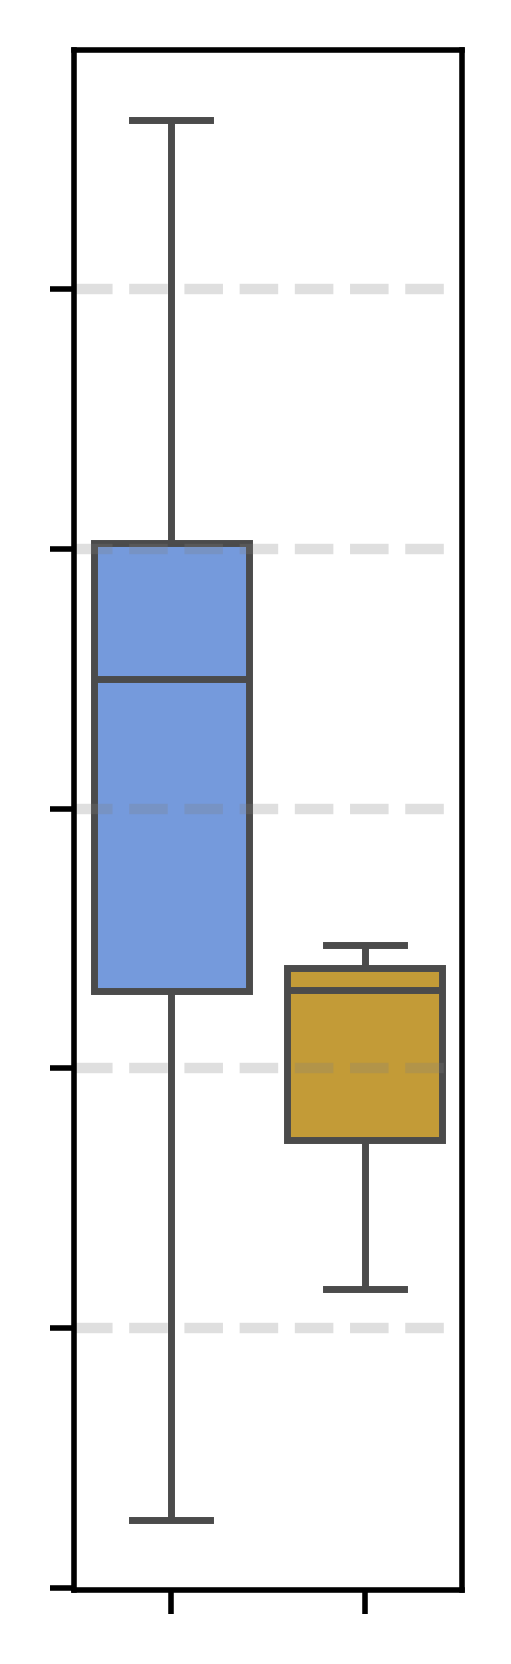

In [11]:
MSI_intensity_by_Patient = list()
for PatientID, edf in adata_c.obs[(adata_c.obs['NumSTRLoci']>=10) & (adata_c.obs['Manual_CellType_lvl_1']=='Tumor epithelial')].groupby('PatientID', observed=True):
    MSI_intensity_by_Patient.append( [PatientID, np.mean(edf['MSI_score']), edf.iloc[0].Response] )
MSI_intensity_by_Patient = pd.DataFrame(MSI_intensity_by_Patient, columns=['PatientID', 'Mean_MSI_score', 'Response'])

plt.figure(figsize=(1, 4), dpi=500)
ax = sns.boxplot(data=MSI_intensity_by_Patient, 
                 x='Response', y='Mean_MSI_score',  palette=['cornflowerblue', 'goldenrod'], 
                 whis=(0, 100))
# ax = sns.stripplot(data=STRProfileByLength2[STRProfileByLength2['isTumor']==True], x='Response', y='MSI_score', color='black',
#                    jitter=0, alpha=0.5,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
for i in [ 2, 3, 4, 5, 6 ]:
    plt.axhline( i, color='gray', ls='--', alpha=0.25, )
plt.show()


In [12]:
MSI_intensity_by_Patient['TumorRegressionRatio'] = [ dict_PatientID_to_TumorRegressionRatio[PatientID] for PatientID in MSI_intensity_by_Patient['PatientID'] ]

0.491 0.149
0.917 0.001


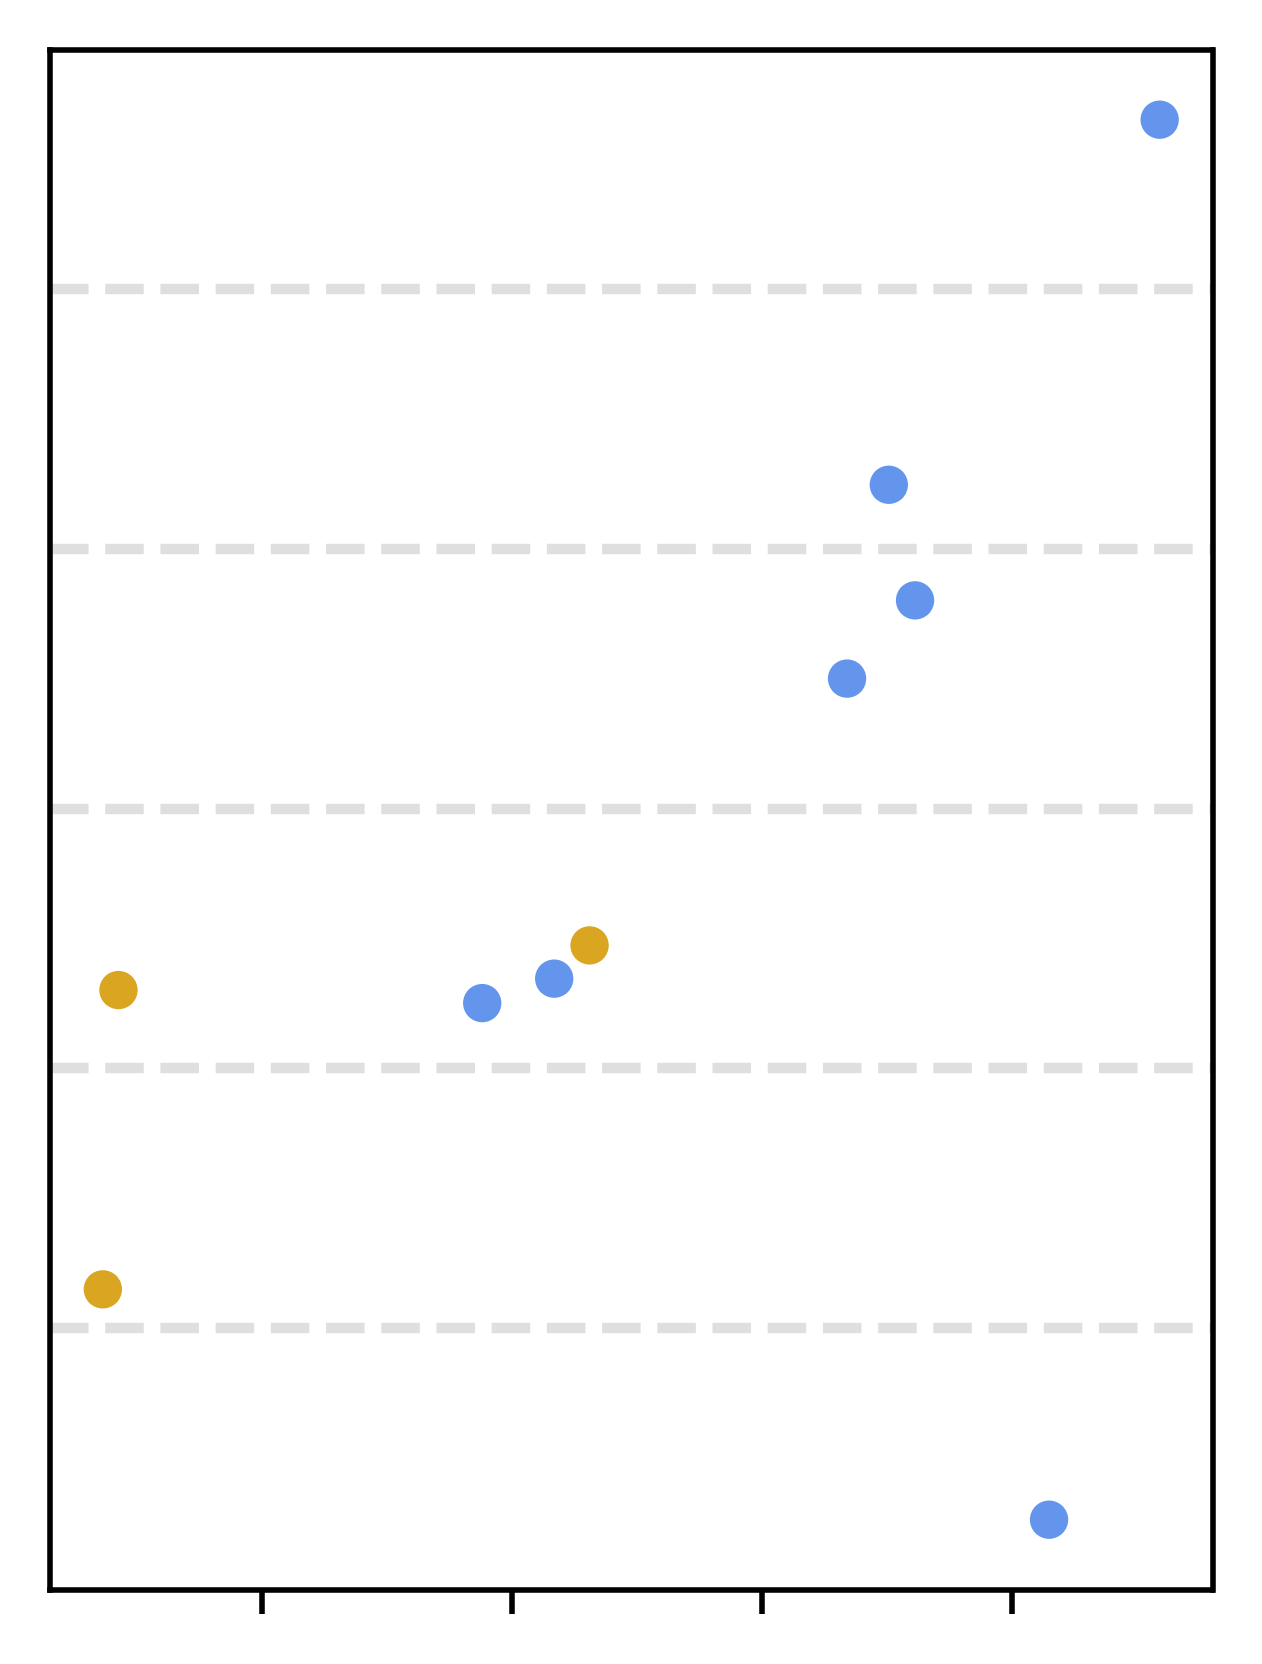

In [18]:
plt.figure(figsize=(3, 4), dpi=500)
ax = sns.scatterplot(data=MSI_intensity_by_Patient.sort_values('Mean_MSI_score'), 
                 x='TumorRegressionRatio', y='Mean_MSI_score', 
                 hue='Response', palette=['cornflowerblue', 'goldenrod'],
                 legend=None,)
ax.set_xlabel('');
ax.set_ylabel('');
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.set_yticks([]);

for i in [ 2, 3, 4, 5, 6 ]:
    plt.axhline( i, color='gray', ls='--', alpha=0.25, )

r, pval = stats.pearsonr(MSI_intensity_by_Patient['TumorRegressionRatio'], MSI_intensity_by_Patient['Mean_MSI_score'])
print(round(r, 3), round(pval, 3))
r, pval = stats.pearsonr(MSI_intensity_by_Patient[(MSI_intensity_by_Patient['PatientID']!='P18')]['TumorRegressionRatio'], 
                         MSI_intensity_by_Patient[(MSI_intensity_by_Patient['PatientID']!='P18')]['Mean_MSI_score'])
print(round(r, 3), round(pval, 3))
plt.show()

## Annotate Joanito et al. cell types in more detail (Extended Data Fig. ??)

In [33]:
def preprocess( adata, batch_key="SampleID" ):
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=batch_key)
    
    adata.raw = adata.copy()
    adata = adata[:, adata.var.highly_variable]

    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata, random_state=42)
    
    return adata

In [7]:
dict_Identifier_to_lvl_1_CellType = dict()
dict_Identifier_to_lvl_2_CellType = dict()

In [8]:
adata_j_TME = adata_j[adata_j.obs['Manual_CellType_lvl_1']!='Tumor epithelial'].copy()
adata_j_TME = adata_j_TME.raw.to_adata()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2025-04-15 15:11:39.162226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-15 15:11:39.242208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 15:11:40.194370: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-15 15:11:40.444621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 

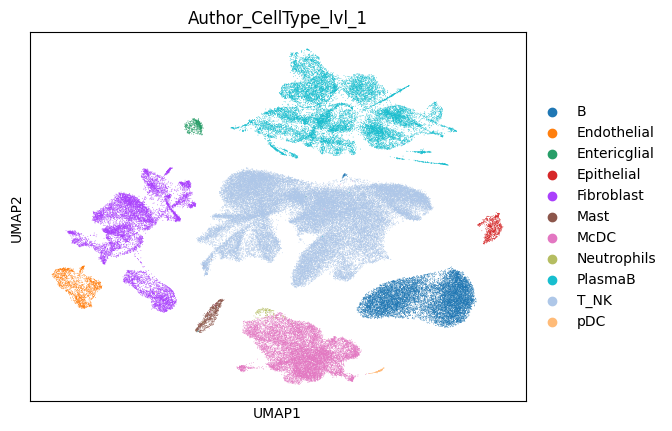

In [12]:
preprocess(adata_j_TME, batch_key='SampleID')

sc.tl.leiden(adata_j_TME, resolution=0.1, key_added='leiden_res_0.1')
sc.pl.umap(adata_j_TME, color=['Author_CellType_lvl_1'])

### B & Plasma

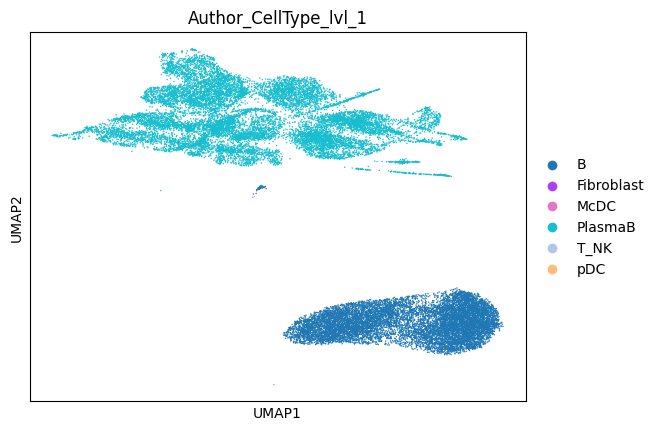

In [24]:
adata_j_TME_B = adata_j_TME[adata_j_TME.obs['leiden_res_0.1'].isin(['3', '4', '6',])].copy()
sc.pl.umap(adata_j_TME_B, color=['Author_CellType_lvl_1'])
adata_j_TME_B = adata_j_TME_B.raw.to_adata()

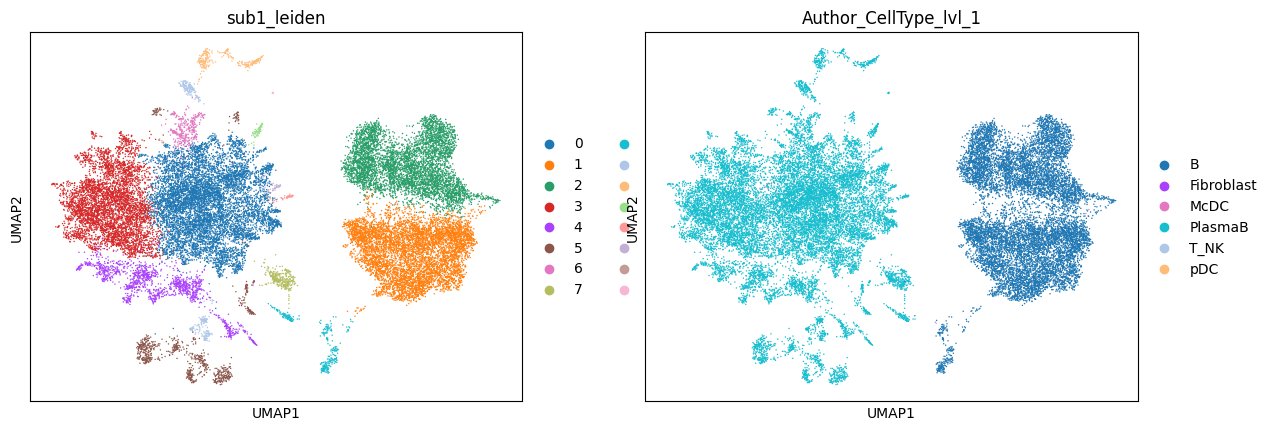

In [30]:
temp = list()
for SampleID, edf in adata_j_TME_B.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Plasma'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_j_TME_B = adata_j_TME_B[~(adata_j_TME_B.obs['SampleID'].isin(temp))].copy()

adata_j_TME_B = preprocess(adata_j_TME_B, batch_key="SampleID")
sc.tl.leiden(adata_j_TME_B, resolution=0.3, key_added='sub1_leiden',)
sc.pl.umap(adata_j_TME_B, color=['sub1_leiden', 'Author_CellType_lvl_1'], )

#### Sub-clustering: sub1_leiden 1, 2, 8

In [34]:
adata_j_TME_B_Plasma = adata_j_TME_B[~(adata_j_TME_B.obs['sub1_leiden'].isin(['1', '2', '8']))].copy()
adata_j_TME_B_Plasma = adata_j_TME_B_Plasma.raw.to_adata()

adata_j_TME_B_Plasma = preprocess(adata_j_TME_B_Plasma, batch_key=None)
sc.tl.leiden(adata_j_TME_B_Plasma, resolution=0.5, key_added='sub2_leiden')

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


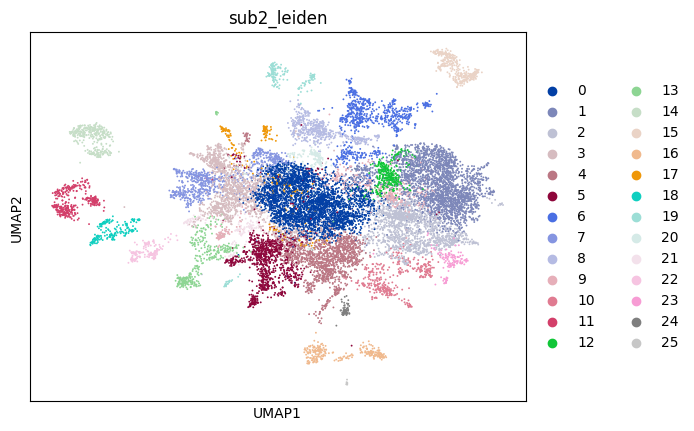

In [37]:
sc.pl.umap(adata_j_TME_B_Plasma, color=['sub2_leiden'])

##### Sub-clustering: sub2_leiden 6, 9, 10, 15

In [38]:
adata_j_TME_B_Plasma_subset1 = adata_j_TME_B_Plasma[adata_j_TME_B_Plasma.obs['sub2_leiden'].isin(['6', '9', '10', '15'])].copy()
adata_j_TME_B_Plasma_subset1 = adata_j_TME_B_Plasma_subset1.raw.to_adata()

temp = list()
for SampleID, edf in adata_j_TME_B_Plasma_subset1.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Plasma'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_j_TME_B_Plasma_subset1 = adata_j_TME_B_Plasma_subset1[~(adata_j_TME_B_Plasma_subset1.obs['SampleID'].isin(temp))].copy()

adata_j_TME_B_Plasma_subset1 = preprocess(adata_j_TME_B_Plasma_subset1)
sc.tl.leiden(adata_j_TME_B_Plasma_subset1, resolution=0.3, key_added='sub3_leiden')

/tmp/ipykernel_282092/145185743.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf in adata_j_TME_B_Plasma_subset1.obs.groupby('SampleID'):
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)
/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


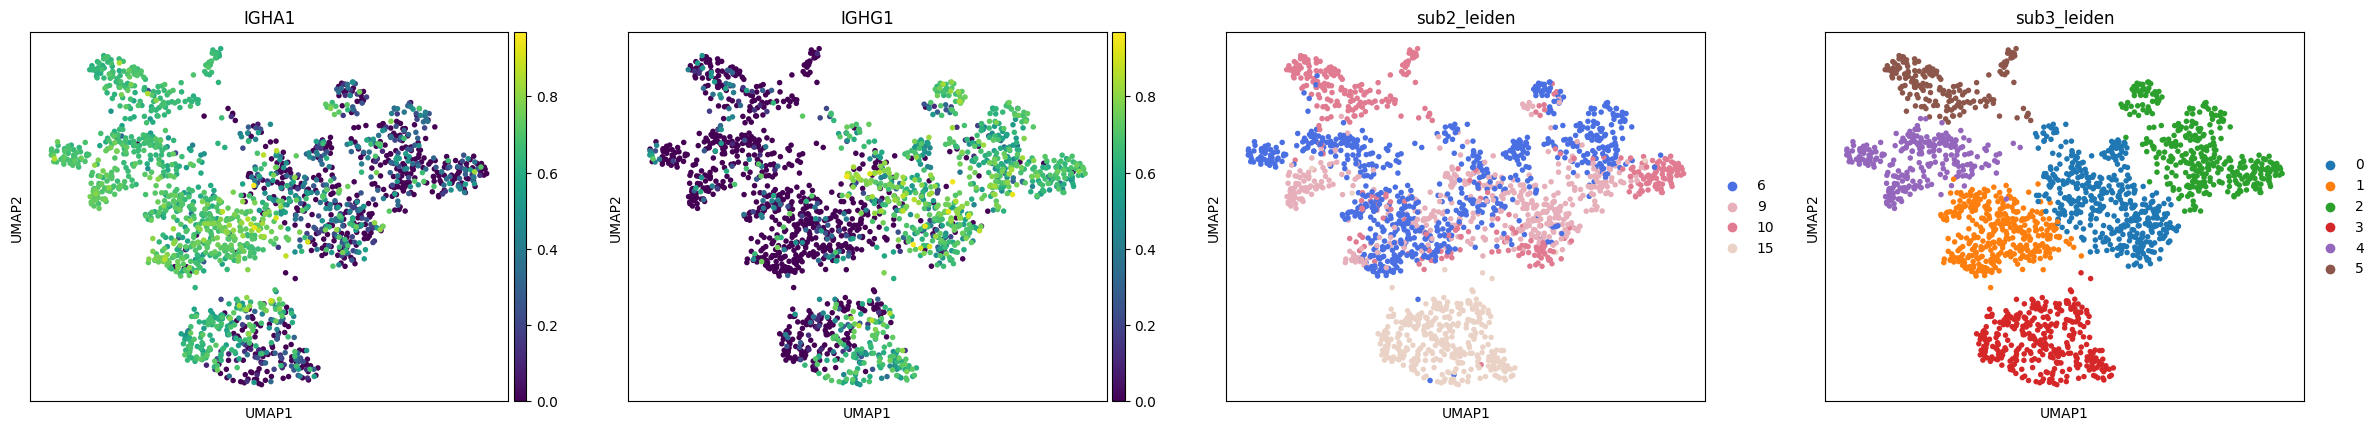

In [42]:
sc.pl.umap(adata_j_TME_B_Plasma_subset1, color=['IGHA1', 'IGHG1', 'sub2_leiden', 'sub3_leiden'], ncols=4)

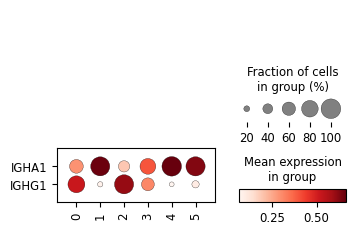

In [41]:
sc.pl.dotplot(adata_j_TME_B_Plasma_subset1, var_names=['IGHA1', 'IGHG1',], groupby='sub3_leiden', swap_axes=True)

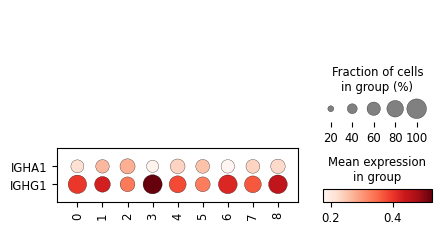

In [45]:
# sub3_leiden 0 consists of a mixture of IGHA+ and IGHG+ Plasma cells

adata_j_TME_B_Plasma_subset1_l0 = adata_j_TME_B_Plasma_subset1[adata_j_TME_B_Plasma_subset1.obs['sub3_leiden'].isin(['0',])].copy()
adata_j_TME_B_Plasma_subset1_l0 = adata_j_TME_B_Plasma_subset1_l0.raw.to_adata()

temp = list()
for SampleID, edf in adata_j_TME_B_Plasma_subset1_l0.obs.groupby('SampleID'):
    if len(edf) <= 1:
        temp.append( SampleID )
        dict_Identifier_to_lvl_1_CellType[edf.iloc[0].Identifier] = 'Plasma'
        dict_Identifier_to_lvl_2_CellType[edf.iloc[0].Identifier] = 'N/A'

adata_j_TME_B_Plasma_subset1_l0 = adata_j_TME_B_Plasma_subset1_l0[~(adata_j_TME_B_Plasma_subset1_l0.obs['SampleID'].isin(temp))].copy()

adata_j_TME_B_Plasma_subset1_l0 = preprocess(adata_j_TME_B_Plasma_subset1_l0, n_neighbors=5, batch_key="SampleID")
sc.tl.leiden(adata_j_TME_B_Plasma_subset1_l0, resolution=1.0, key_added='sub4_leiden')
sc.pl.dotplot(adata_j_TME_B_Plasma_subset1_l0, var_names=['IGHA1', 'IGHG1',], groupby='sub4_leiden', swap_axes=True)

In [ ]:
for tup in adata_j_TME_B_Plasma_subset1_l0[(adata_j_TME_B_Plasma_subset1_l0.obs['sub4_leiden'].isin(['8',]))].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Plasma'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'IGHG+ Plasma'
    
for tup in adata_j_TME_B_Plasma_subset1_l0[~(adata_j_TME_B_Plasma_subset1_l0.obs['sub4_leiden'].isin(['8']))].obs.itertuples():
    dict_Identifier_to_lvl_1_CellType[tup.Identifier] = 'Plasma'
    dict_Identifier_to_lvl_2_CellType[tup.Identifier] = 'N/A'

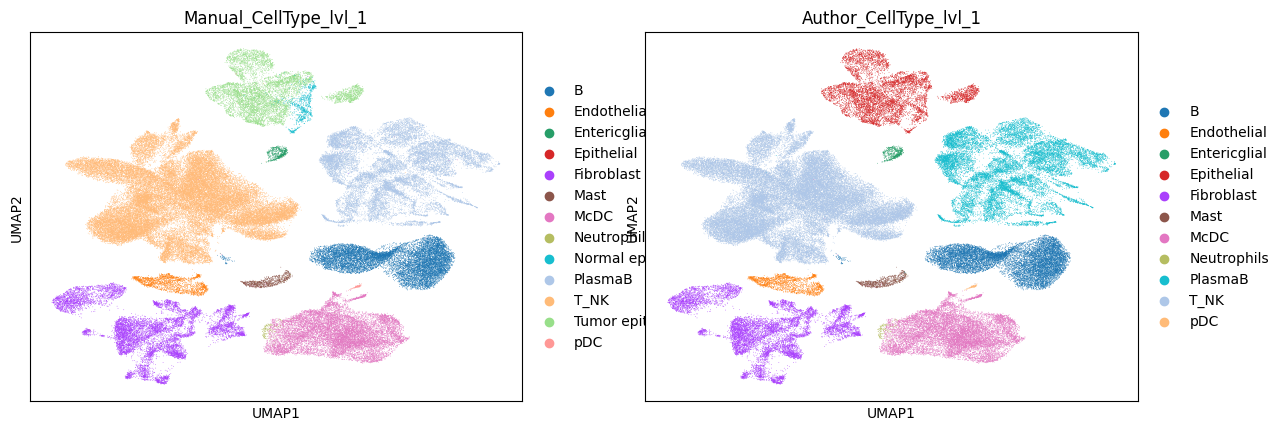

In [6]:
sc.pl.umap(adata_j, color=['Manual_CellType_lvl_1', 'Author_CellType_lvl_1'])

In [ ]:
CellTypeProportionByPatient = list()
#PatientID_blacklist = ['SC044']

for PatientID, edf in adata_j[~(adata_j.obs['Manual_CellType_lvl_3'].isin(['Tumor cell', 'Goblet', 'Transit-amplifying cell', 'Enterocytes', 'Intestinal stem cell', 'N/A'])) & # Exclude epithelial cells
                                    (adata_j.obs['BiopsySite2']!='LymphNode') &   # Exclude LymphNode samples
                                    (adata_j.obs['MSI']=='MSI-H')].obs.groupby('PatientID', observed=True,):
    for BiopsySite2, edf2 in edf.groupby("BiopsySite2", observed=True):
        for CellType, edf3 in edf2.groupby('Manual_CellType_lvl_3', observed=True,):            
            CellTypeProportionByPatient.append( [PatientID, edf.iloc[0].MSI, BiopsySite2, CellType, len(edf3), len(edf3)/len(edf2) ] )
            
CellTypeProportionByPatient = pd.DataFrame(CellTypeProportionByPatient, columns=['PatientID', 'MSI',  'BiopsySite', 'CellType', 'Count', 'Proportion'])
# CellTypeProportionByPatient.to_csv('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/4_TME/CellTypeProportion.tsv', sep='\t', index=False)

In [ ]:
adata_c.obs['Author_CellType_lvl_1b'] = [ dict_AuthorCellType_to_lvl_2b_CellType[ACT] for ACT in adata_c.obs['Author_CellType_lvl_2'] ]